### Chris Hamm 2019-09-23 (initial code)
A jupyter notebook to add *Neonympha* images from google images. 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%autosave 60

Autosaving every 60 seconds


In [2]:
from fastai import *
from fastai.vision import *

In [3]:
np.random.seed(1138)

Now prepare to download the files to our repo

Nar

In [4]:
gimage_path = "../data/images/"

In [ ]:
Nar_folder = "Nar"
Nar_file = "Nar_photos.txt"
Nar_path = Path('../data/images/Nar')
Nar_dest = Nar_path/Nar_folder
Nar_dest.mkdir(parents = True, exist_ok = True)

Nmi

In [ ]:
Nmi_folder = "Nmi"
Nmi_file = "Nmi_photos.txt"
Nmi_path = Path('../data/images/Nmi')
Nmi_dest = Nmi_path/Nmi_folder
Nmi_dest.mkdir(parents = True, exist_ok = True)

Nfr

In [ ]:
Nfr_folder = "Nfr"
Nfr_file = "Nfr_photos.txt"
Nfr_path = Path('../data/images/Nfr')
Nfr_dest = Nfr_path/Nfr_folder
Nfr_dest.mkdir(parents = True, exist_ok = True)

Nhe

In [ ]:
Nhe_folder = "Nhe"
Nhe_file = "Nhe_photos.txt"
Nhe_path = Path('../data/images/Nhe')
Nhe_dest = Nhe_path/Nhe_folder
Nhe_dest.mkdir(parents = True, exist_ok = True)

Download the images

In [5]:
classes = ['Nar', 'Nmi', 'Nfr', 'Nhe']

In [ ]:
#download_images(Nar_path/Nar_file, Nar_dest, max_pics = 50)
#download_images(Nmi_path/Nmi_file, Nmi_dest, max_pics = 50)
#download_images(Nfr_path/Nfr_file, Nfr_dest, max_pics = 50)
#download_images(Nhe_path/Nhe_file, Nhe_dest, max_pics = 50)

In [8]:
gimage_data = ImageDataBunch.from_folder(path = gimage_path, train = ".", 
                                         valid_pct = 0.2, ds_tfms = get_transforms(),
                                        size = 224, num_workers = 4, bs = 64).normalize(imagenet_stats)

In [7]:
gimage_data

ImageDataBunch;

Train: LabelList (462 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Nar,Nar,Nar,Nar,Nar
Path: ../data/images;

Valid: LabelList (115 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Nar,Nar,Nhe,Nmi,Nmi
Path: ../data/images;

Test: None

In [8]:
print(gimage_data.classes)

['Nar', 'Nfr', 'Nhe', 'Nmi']


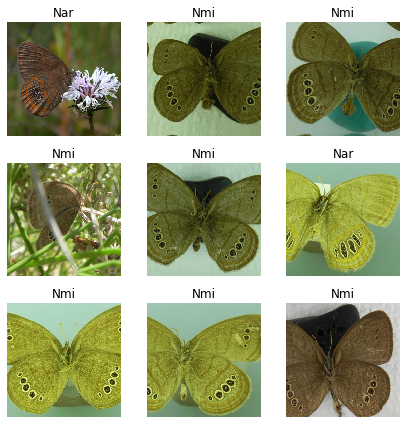

In [9]:
gimage_data.show_batch(rows = 3, figsize = (6, 6))

### `resnet34`

In [ ]:
gimage_learn34 = cnn_learner(gimage_data, models.resnet34, metrics = error_rate)

In [ ]:
gimage_learn34.fit_one_cycle(4) 
# with default LR, get error rate of 15%

In [ ]:
ginterpretation34 = ClassificationInterpretation.from_learner(gimage_learn34)

glosses34, gidxs34 = ginterpretation34.top_losses()

len(gimage_data.valid_ds) == len(glosses34) == len(gidxs34)

In [ ]:
ginterpretation34.plot_top_losses(6, figsize = (15, 11))

In [ ]:
ginterpretation34.plot_confusion_matrix(figsize = (6, 6), dpi = 200)

In [ ]:
ginterpretation34.most_confused(min_val = 0) 

### Tweak the LR and N epochs

Learning rates

In [ ]:
#gimage_learn34.fit_one_cycle(4, max_lr = 0.5) # crazy high

In [ ]:
#gimage_learn34.fit_one_cycle(4, max_lr = 1e-5) # crazy low, never want a model where training loss is higher than validation loss. Always means you have not trained enough

In [ ]:
#gimage_learn34.recorder.plot_losses()

In [ ]:
gimage_learn34.fit_one_cycle(1) #TL higher than VL

Overfitting

In [7]:
# too many epochs is overfitting
gimage_data = ImageDataBunch.from_folder(path = gimage_path, train = ".", 
                                         valid_pct = 0.9, ds_tfms = get_transforms(do_flip = False, max_rotate = 0, max_zoom = 1,
                                         max_lighting = 0, max_warp = 0),
                                        size = 224, num_workers = 4, bs = 32).normalize(imagenet_stats)

In [ ]:
glearn = cnn_learner(gimage_data, models.resnet50, 
                     metrics = error_rate, ps = 0, wd = 0)

In [ ]:
glearn.fit_one_cycle(40, slice(1e-6, 1e-4)) # error rate improves and then gets worse

In [ ]:
# It is OK for train loss to be lower than valid loss. That is what you want.
# As long as you are training and error is improving you are not overfitting.

### `resnet50`

In [9]:
gimage_learn50 = cnn_learner(gimage_data, models.resnet50, metrics = error_rate)

In [10]:
gimage_learn50.fit_one_cycle(4) # 7% error after 4 cycles

epoch,train_loss,valid_loss,error_rate,time
0,1.576897,0.815611,0.278261,00:20
1,0.988649,0.468922,0.130435,00:18
2,0.752593,0.389257,0.069565,00:18
3,0.599533,0.336734,0.078261,00:18


In [11]:
ginterpretation50 = ClassificationInterpretation.from_learner(gimage_learn50)

glosses50, gidxs50 = ginterpretation50.top_losses()

len(gimage_data.valid_ds) == len(glosses50) == len(gidxs50)

True

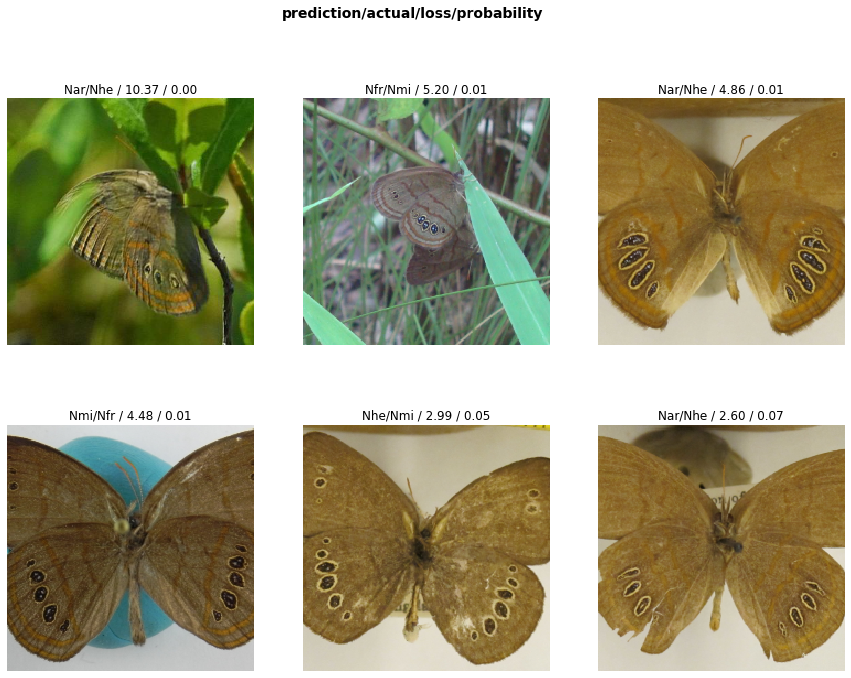

In [12]:
ginterpretation50.plot_top_losses(6, figsize = (15, 11))

In [13]:
ginterpretation50.most_confused(min_val = 0) 

[('Nhe', 'Nar', 4),
 ('Nfr', 'Nmi', 2),
 ('Nar', 'Nmi', 1),
 ('Nmi', 'Nfr', 1),
 ('Nmi', 'Nhe', 1),
 ('Nar', 'Nar', 0),
 ('Nar', 'Nfr', 0),
 ('Nar', 'Nhe', 0),
 ('Nfr', 'Nar', 0),
 ('Nfr', 'Nfr', 0),
 ('Nfr', 'Nhe', 0),
 ('Nhe', 'Nfr', 0),
 ('Nhe', 'Nhe', 0),
 ('Nhe', 'Nmi', 0),
 ('Nmi', 'Nar', 0),
 ('Nmi', 'Nmi', 0)]

### Trying larger images

In [20]:
gimage_data2 = ImageDataBunch.from_folder(path = gimage_path, train = ".", 
                                         valid_pct = 0.25, ds_tfms = get_transforms(),
                                        size = 294, num_workers = 4, bs = 16).normalize(imagenet_stats)

In [21]:
gimage_learn50b = cnn_learner(gimage_data2, models.resnet50, metrics = error_rate)

In [22]:
gimage_learn50b.fit_one_cycle(4) # after 4 cycles error is 9%
# increasing the image size to 350 does not improve error

epoch,train_loss,valid_loss,error_rate,time
0,1.362239,0.468699,0.118056,00:16
1,0.856977,0.832898,0.131944,00:16
2,0.658911,0.459377,0.097222,00:16
3,0.457710,0.427039,0.090278,00:16


Larger images still

In [6]:
gimage_data3 = ImageDataBunch.from_folder(path = gimage_path, train = ".", 
                                         valid_pct = 0.25, ds_tfms = get_transforms(),
                                        size = 350, num_workers = 4, bs = 8).normalize(imagenet_stats)

In [9]:
gimage_learn50c = cnn_learner(gimage_data3, models.resnet50, metrics = error_rate)

In [10]:
gimage_learn50c.fit_one_cycle(6) # after 4 cycles error is

epoch,train_loss,valid_loss,error_rate,time
0,1.367450,0.904063,0.166667,00:18
1,0.948731,0.481659,0.111111,00:17
2,0.792106,0.428331,0.145833,00:18
3,0.585179,0.422648,0.111111,00:17
4,0.406161,0.372005,0.125000,00:17
5,0.312944,0.358069,0.125000,00:17
